In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv1D, Conv1DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling1D, UpSampling1D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

In [3]:
def load_dataset():
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if alpha == 0.2 and beta == 0.4:
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                print('Alpha, Beta is {} and given label {}'.format(pair, file_index))
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [4]:
X, y, file_index = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(X_train.shape)

Alpha, Beta is (0.2, 0.4) and given label 1
(10000, 100)


In [5]:
X_train.shape[0]

10000

In [6]:
new_X_train = []
for i in range(X_train.shape[0]):
    new_X_train.append(np.array([X_train.iloc[i]]).T)
    
new_X_test = []
for i in range(X_test.shape[0]):
    new_X_test.append(np.array([X_test.iloc[i]]).T)

In [7]:
new_X_train = np.array(new_X_train)
new_X_test = np.array(new_X_test)

In [8]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
original_dim = 100
intermediate_dim = 75
intermediate_dim2 = 50
intermediate_dim3 = 25
latent_dim = 2

In [68]:
#inputs = Input((None, original_dim), name='input')
inputs = Input(shape=(original_dim, 1), name='input')

x = Conv1D(2, kernel_size=3, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(4, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(8, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)

# Flatten, ready for dense layers
x = Flatten()(x)
x = Dense(2*latent_dim, activation='relu')(x)

# Means and log(variances) layers both connected to previous dense layer
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [69]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 100, 2)       8           input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_22 (MaxPooling1D) (None, 50, 2)        0           conv1d_27[0][0]                  
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 50, 4)        28          max_pooling1d_22[0][0]           
____________________________________________________________________________________________

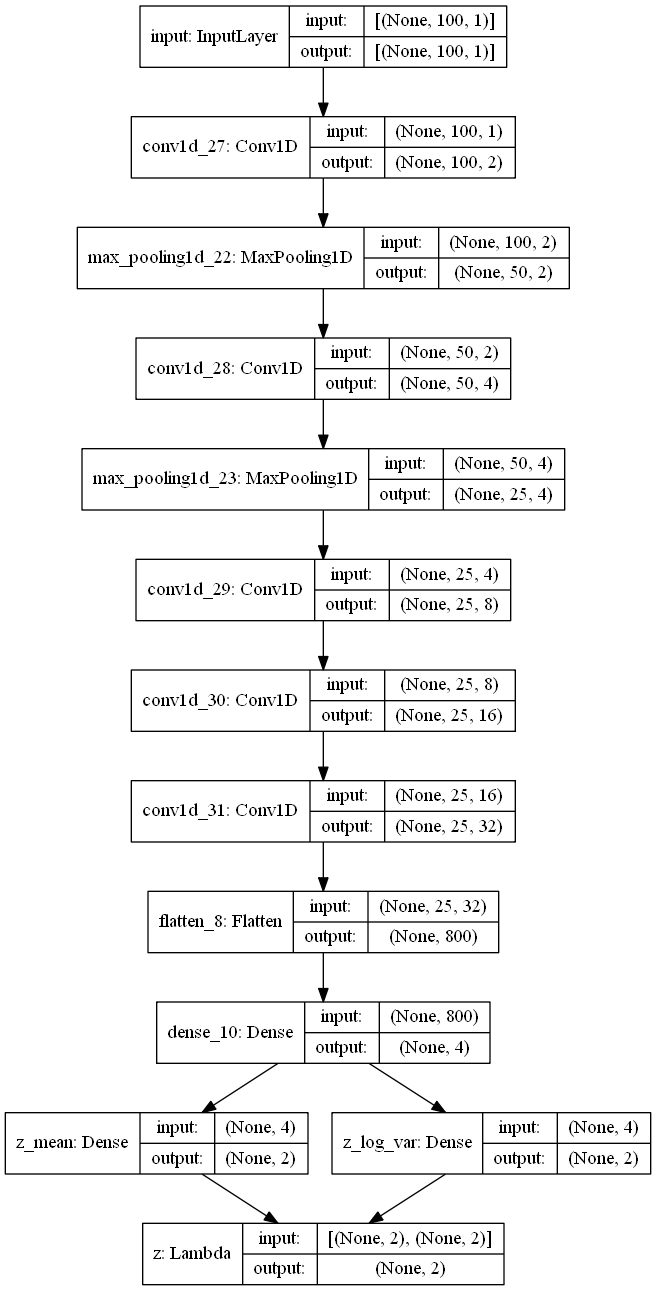

In [70]:
plot_model(encoder, show_shapes=True)

In [74]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(25*32, activation='relu')(latent_inputs)
x = Reshape((25, 32))(x)
x = Conv1DTranspose(32, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1DTranspose(16, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1DTranspose(8, kernel_size=3, padding='same', activation='relu')(x)
x = UpSampling1D(size=2)(x)
x = Conv1DTranspose(4, kernel_size=3, padding='same', activation='relu')(x)
x = UpSampling1D(size=2)(x)
x = Conv1DTranspose(2, kernel_size=3, padding='same', activation='relu')(x)
outputs = Conv1DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

In [75]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 800)               2400      
_________________________________________________________________
reshape_7 (Reshape)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_transpose_34 (Conv1DT (None, 25, 32)            3104      
_________________________________________________________________
conv1d_transpose_35 (Conv1DT (None, 25, 16)            1552      
_________________________________________________________________
conv1d_transpose_36 (Conv1DT (None, 25, 8)             392       
_________________________________________________________________
up_sampling1d_21 (UpSampling (None, 50, 8)             0   

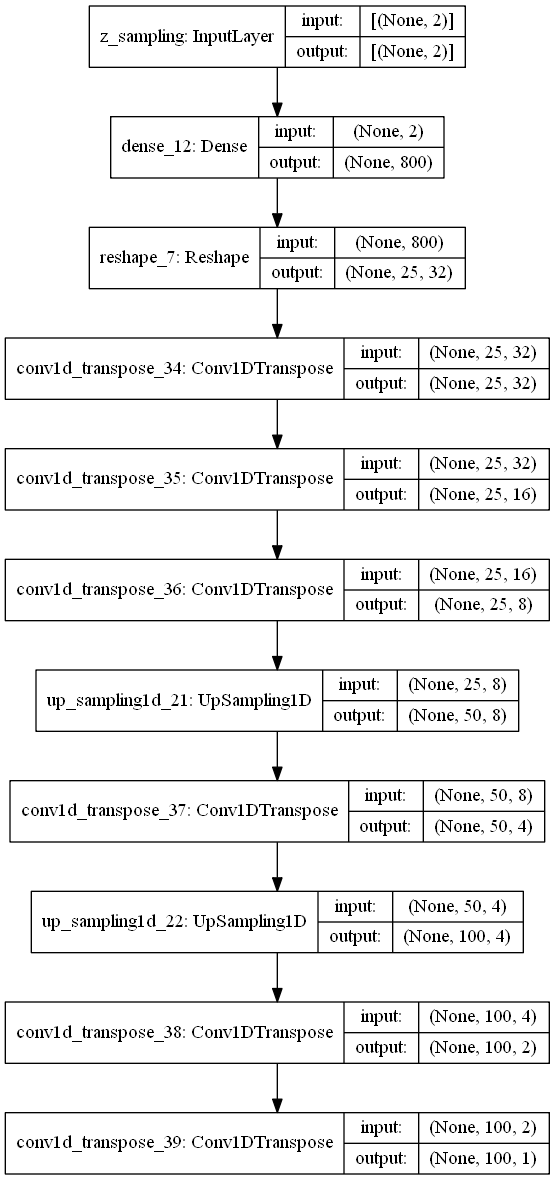

In [76]:
plot_model(decoder, show_shapes=True)

In [77]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [78]:
vae = Model(i, o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 1)]          0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 5332      
_________________________________________________________________
decoder (Functional)         (None, 100, 1)            7581      
Total params: 12,913
Trainable params: 12,913
Non-trainable params: 0
_________________________________________________________________


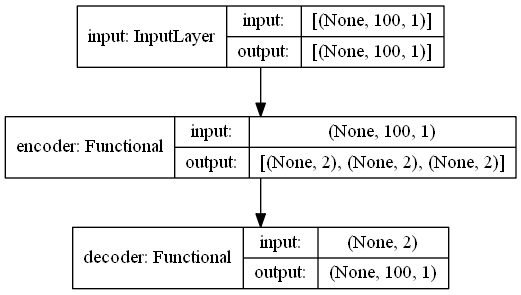

In [79]:
plot_model(vae, show_shapes=True)

In [80]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        #reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        reco_loss_value = K.sum(reco_loss_value)
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [81]:
# Define parameters
nb_epochs  =  10
batch_size = 100

In [82]:
# Compile with given compile function to include custom VAE loss function
compile_vae(vae)

vae_history = vae.fit(new_X_train, new_X_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 11s 1ms/sample - loss: 5320.1296 - reco_loss: 5319.9365 - kl_loss: 0.1930 - val_loss: 5089.9427 - val_reco_loss: 5089.9346 - val_kl_loss: 0.0075
Epoch 2/10
8000/8000 [==============================] - 10s 1ms/sample - loss: 5055.8713 - reco_loss: 5055.8682 - kl_loss: 0.0034 - val_loss: 5079.1310 - val_reco_loss: 5079.1299 - val_kl_loss: 0.0011
Epoch 3/10
8000/8000 [==============================] - 9s 1ms/sample - loss: 5050.5780 - reco_loss: 5050.5771 - kl_loss: 6.9698e-04 - val_loss: 5078.9707 - val_reco_loss: 5078.9697 - val_kl_loss: 0.0012
Epoch 4/10
8000/8000 [==============================] - 10s 1ms/sample - loss: 5048.7856 - reco_loss: 5048.7573 - kl_loss: 0.0279 - val_loss: 5069.6079 - val_reco_loss: 5069.4219 - val_kl_loss: 0.1857
Epoch 5/10
8000/8000 [==============================] - 10s 1ms/sample - loss: 5030.6047 - reco_loss: 5029.1016 - kl_loss: 1.5032 - val_loss: 504

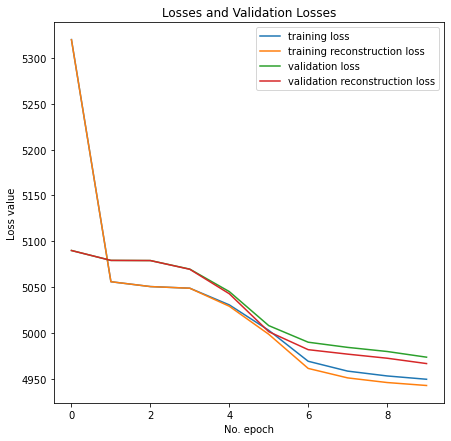

In [83]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
#plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
#plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [84]:
z_mean, _, _ = encoder.predict(new_X_test)

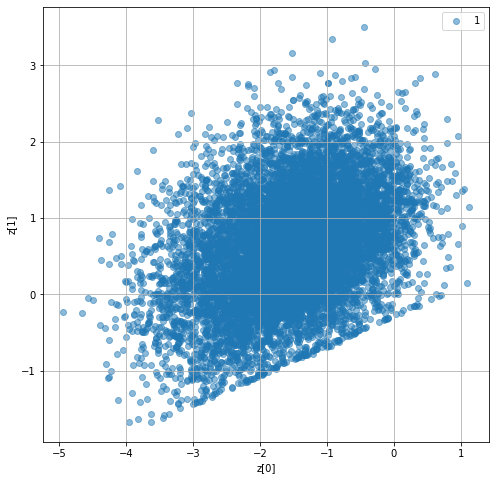

In [85]:
# Create figure and axis objects.
fig, ax = plt.subplots(figsize=(8,8))
# Loop for each digit label
for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current digit on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               single_label[:, 1],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space for next part clear
ax.grid()
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()

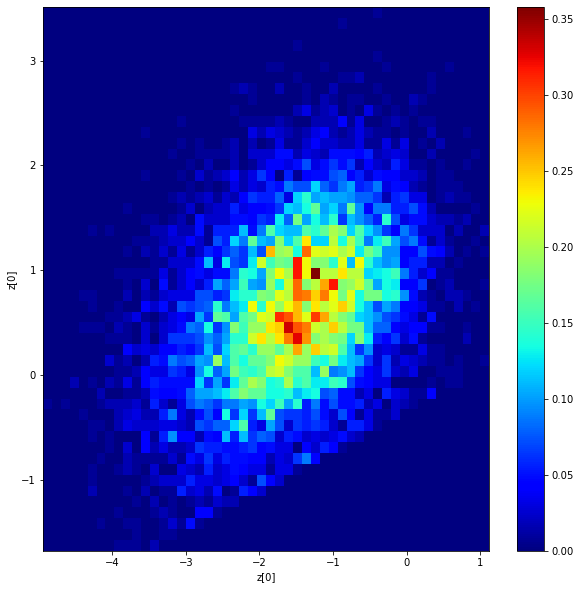

In [86]:
fig = plt.figure(figsize=(10,10))
plt.hist2d(z_mean[:, 0], z_mean[:, 1], bins=50, density=True, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('z[0]')
plt.ylabel('z[0]')

plt.show()

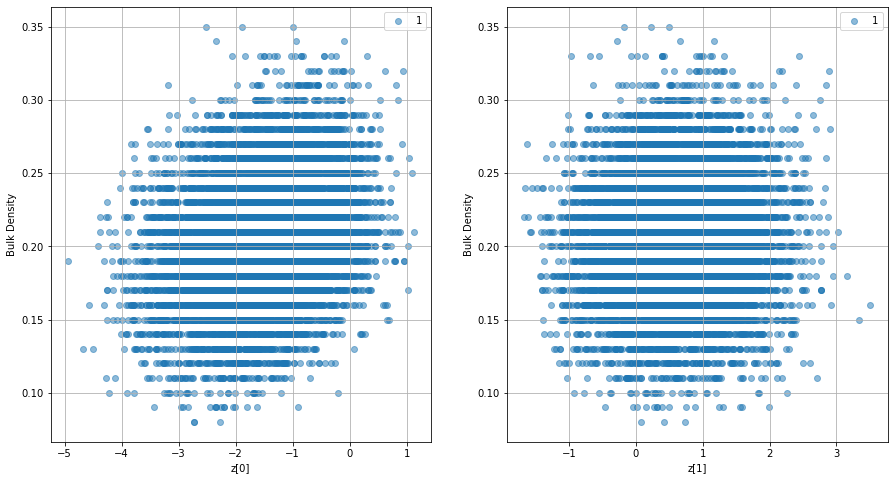

In [87]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].scatter(single_label[:, 0],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    ax[1].scatter(single_label[:, 1],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    pass

# Draw legend
ax[0].legend()
# Include grid lines to make chosen region of latent space clear
ax[0].grid()
ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Bulk Density')
# Draw legend
ax[1].legend()
# Include grid lines to make chosen region of latent space clear
ax[1].grid()
ax[1].set_xlabel('z[1]')
ax[1].set_ylabel('Bulk Density')

plt.show()

In [88]:
X_test_currents = []
for i in range(len(X_test)):
    jumps_possible = 0
    occs = np.array(X_test.iloc[i])
    for j in range(len(occs)): 
        if  j == len(occs)-1 and occs[j] == 1:
            jumps_possible += 1
        elif occs[j] == 1 and occs[j+1] == 0:
            jumps_possible += 1
    X_test_currents.append(jumps_possible / len(occs))
    
X_test_currents = np.array(X_test_currents)

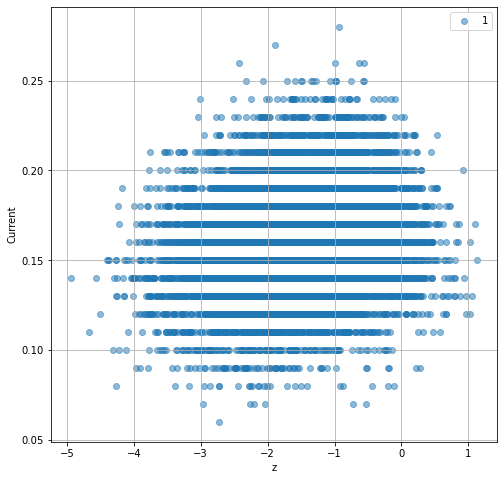

In [89]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               X_test_currents[mask],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Current')

plt.show()

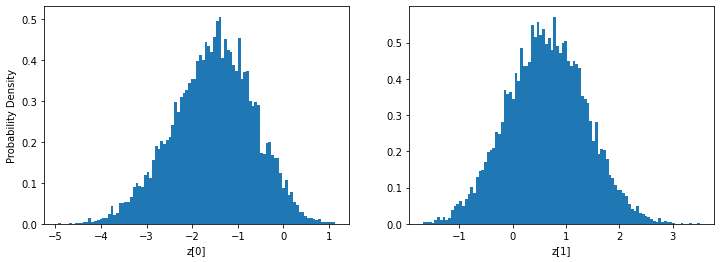

In [90]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
# Make histogram at the 
ax[0].hist(z_mean[:, 0],bins=100, density=True)
ax[1].hist(z_mean[:, 1],bins=100, density=True)

ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Probability Density')
ax[1].set_xlabel('z[1]')

plt.show()

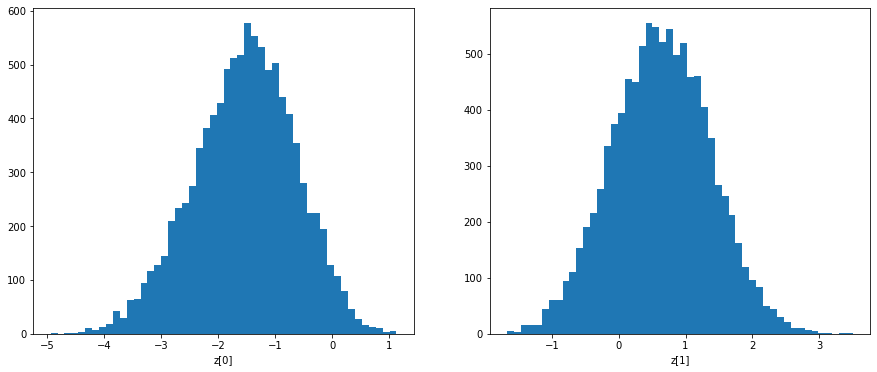

In [91]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].hist(single_label[:, 0],
               bins=50)
    ax[1].hist(single_label[:, 1],
               bins=50)
    pass

ax[0].set_xlabel('z[0]')
ax[1].set_xlabel('z[1]')

plt.show()

In [92]:
type_ones = np.array([[-1.5, 1.0], [2.5, 0.0], [2.5, -0.5], [2.5, -1.0]])
decoder.predict(np.array([type_ones[0]]))

array([[[0.23617065],
        [0.15337434],
        [0.15307766],
        [0.17925459],
        [0.18706572],
        [0.17463553],
        [0.16763493],
        [0.16847926],
        [0.18287203],
        [0.19359633],
        [0.19696784],
        [0.19303027],
        [0.19297245],
        [0.19582704],
        [0.20326197],
        [0.2062586 ],
        [0.20891023],
        [0.21011123],
        [0.21155396],
        [0.21161413],
        [0.2089454 ],
        [0.20756504],
        [0.20747033],
        [0.20870402],
        [0.20795089],
        [0.20407304],
        [0.19904566],
        [0.1954095 ],
        [0.1918712 ],
        [0.18926132],
        [0.18197268],
        [0.17526379],
        [0.16638488],
        [0.16076782],
        [0.15369853],
        [0.14874497],
        [0.14183334],
        [0.13696721],
        [0.13302937],
        [0.13258466],
        [0.13307887],
        [0.13552964],
        [0.1384292 ],
        [0.14213485],
        [0.14969033],
        [0